In [1]:
import imp
import uproot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
helper = imp.load_source('helpfunction','/home/tmettler/Desktop/uBoone/do_plots/helpfunction.py')
#import /home/tmettler/Desktop/uBoone/do_plots/helpfunction as helper
from __future__ import division

import collections
NuCC = imp.load_source('NuCC_function','/home/tmettler/Desktop/uBoone/do_plots/NuCC_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [3]:
# Load input files

inputdir = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/'
outputdir = inputdir+'NumuCC_crt_cut/' 
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

filename_overlay = 'NuCCana_overlay_V.root'
filename_data = 'NuCCana_data_V.root'
filename_ext = 'NuCCana_ext_V.root'
filename_dirt = 'NuCCana_dirt_V.root'
    
tree_name = 'numuCCAna'

In [4]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)

pot_data =      8.039e+18 # tor860_wcut
data_trigger = 1942081.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  22622263.0  #2120135 #5685315 # EXT
'''
pot_data =     1.25795274297e+18# tor860_wcut
data_trigger = 1359818.0*0.4 # E1DCNT
ext_trigger =  1359818.0  #2120135 #5685315 # EXT
pot_overlay = 1.25795274297e+18/0.5
pot_dirt = 1.25795274297e18/0.04
'''
print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]*1.3
scale[overlay] = scale[overlay]*1.3
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	966222
Data: Number of Entries:	34835
Ext: Number of Entries:		263935
Dirt: Number of Entries:	96465

POT: 
Data:		8.039e+18
Ext:		0
Overlay:	1.21058333557e+21
Dirt:		2.9866803255e+20

Scalefactors: 
Data:		1.0
Ext:		0.0858482195172
Overlay:	0.00863278032409
Dirt:		0.0349910230123


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [5]:
if 1:
    filename_overlay = 'NuCCana_overlay_V.rootout.root'
    filename_data = 'NuCCana_data_V.rootout.root'
    filename_ext = 'NuCCana_ext_V.rootout.root'
    filename_dirt = 'NuCCana_dirt_V.rootout.root'

    tree_name = 't_out'

    data, ext, dirt, overlay = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data,ext,dirt,overlay)

    sample = [data,ext,overlay,dirt]
    scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
    name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

    scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale[dirt] = scale[dirt]*1.3
    scale[overlay] = scale[overlay]*1.3

Overlay: Number of Entries:	966221
Data: Number of Entries:	34834
Ext: Number of Entries:		263934
Dirt: Number of Entries:	96464



In [6]:
# Define signals

fidVol = '(Nu_Vx>(-1.55+10) && Nu_Vx<(254.8-10)) && (Nu_Vy>(-115.53+10) && Nu_Vy<(117.47-10)) &&(Nu_Vz>(-0.1+10) && Nu_Vz<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG==13 && MCle_purity>0.5' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG!=13 && MCle_purity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_purity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [7]:
# Load the global variables for access of functions

NuCC.loadGlobal(data,ext,dirt,overlay,scale,tot_num_fidVol,overlay_signals,sample, name, outputdir_png, outputdir_root)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [8]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

First mean: 0.0
First std: 0.0
First mean: 0.0
First std: 0.0
First mean: 0.0
First std: 0.0


Error in <TTreeFormula::Compile>:  Bad numerical expression : "TrackStart_x_sce"
Info in <TSelectorDraw::AbortProcess>: Variable compilation failed: {MCle_Vx-TrackStart_x_sce,MCle_Vx!=-999}
Warning in <Fit>: Fit data is empty 
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crt_cut//png/h_pos_Vx.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crt_cut//root/h_pos_Vx.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Error in <TTreeFormula::Compile>:  Bad numerical expression : "TrackStart_y_sce"
Info in <TSelectorDraw::AbortProcess>: Variable compilation failed: {MCle_Vy-TrackStart_y_sce,MCle_Vy!=-999}
Warning in <Fit>: Fit data is empty 
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crt_cut//png/h_pos_Vy.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler

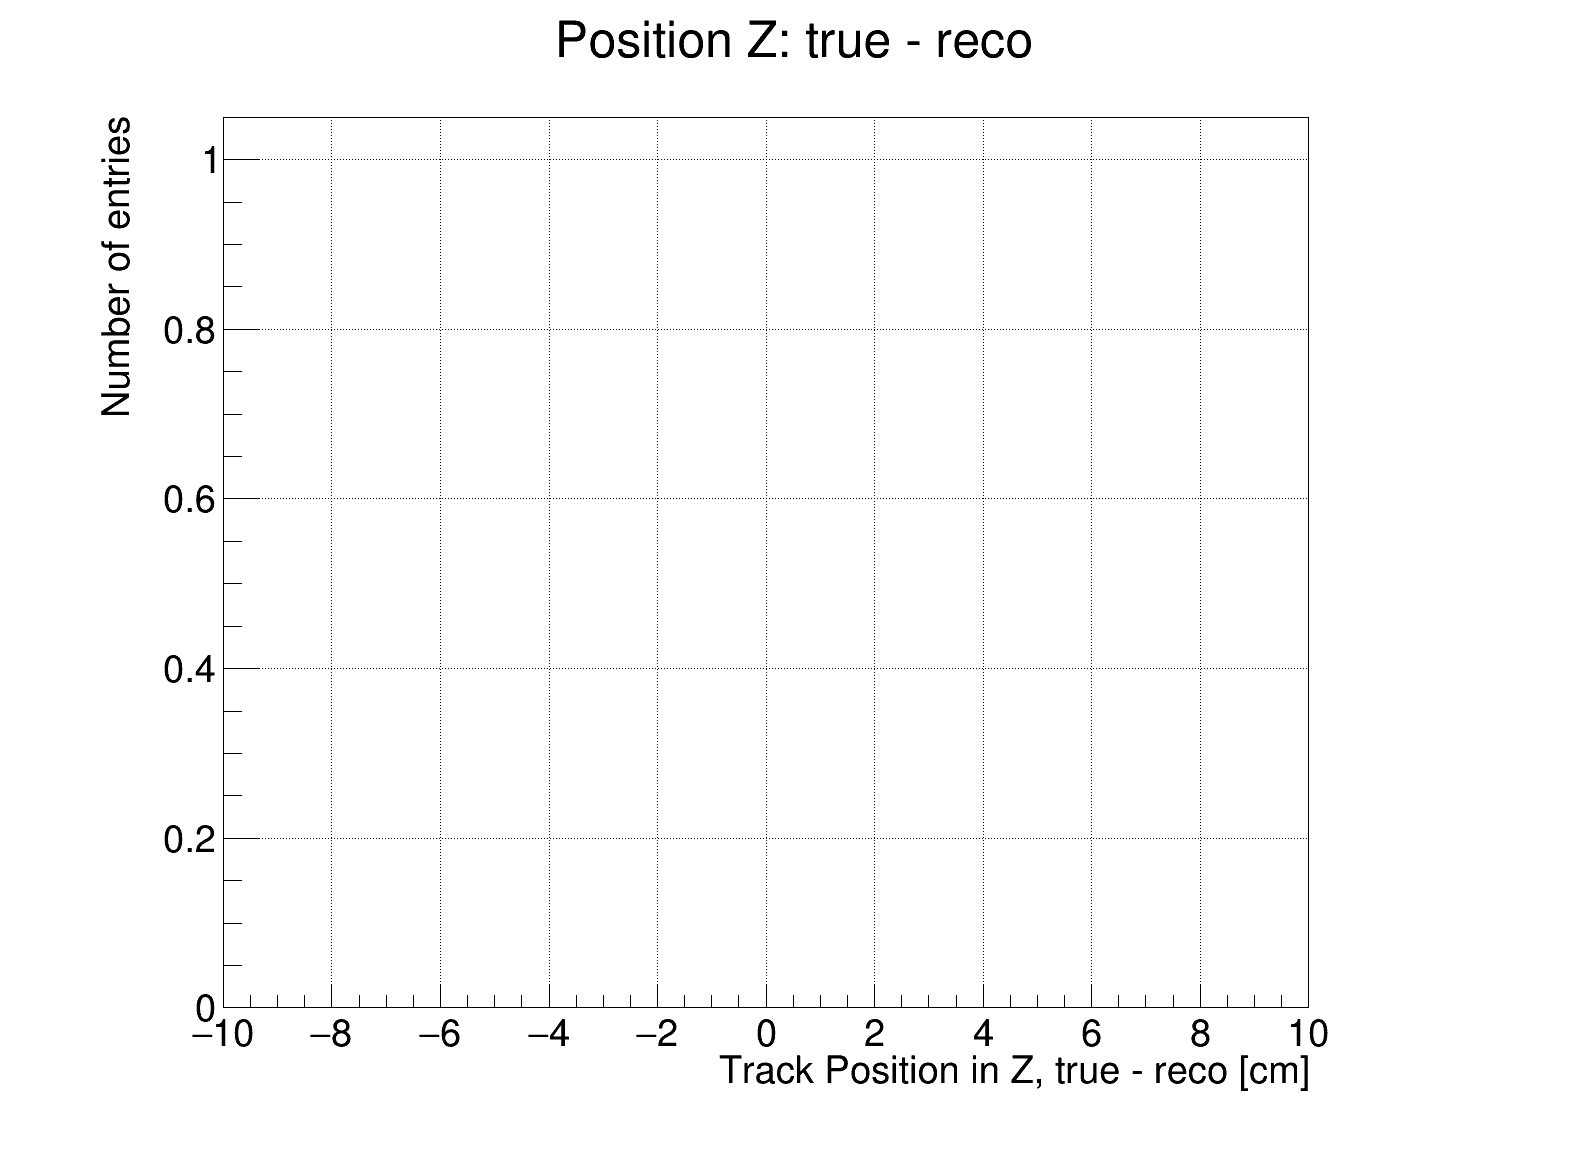

In [9]:
title = 'Position X: true - reco'
name = 'Vx'
xstart = -10
xend = 10
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(1)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
overlay.Draw('MCle_Vx-TrackStart_x_sce>>h_pos','MCle_Vx!=-999')
h_pos.SetXTitle("Track Position in X, true - reco [cm]")
h_pos.SetYTitle("Number of entries")
f1 = ROOT.TF1("f1","gaus",xstart,xend)
h_pos.Fit("f1","R");
print 'First mean:', f1.GetParameter(1)
print 'First std:', f1.GetParameter(2)
h_pos.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

title = 'Position Y: true - reco'
name = 'Vy'
xstart = -10
xend = 10
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(1)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
overlay.Draw('MCle_Vy-TrackStart_y_sce>>h_pos','MCle_Vy!=-999')
h_pos.SetXTitle("Track Position in Y, true - reco [cm]")
h_pos.SetYTitle("Number of entries")
f1 = ROOT.TF1("f1","gaus",xstart,xend)
h_pos.Fit("f1","R");
print 'First mean:', f1.GetParameter(1)
print 'First std:', f1.GetParameter(2)
h_pos.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

title = 'Position Z: true - reco'
name = 'Vz'
xstart = -10
xend = 10
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(1)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
overlay.Draw('MCle_Vz-TrackStart_z_sce>>h_pos','MCle_Vz!=-999')
h_pos.SetXTitle("Track Position in Z, true - reco [cm]")
h_pos.SetYTitle("Number of entries")
f1 = ROOT.TF1("f1","gaus",xstart,xend)
h_pos.Fit("f1","R");
print 'First mean:', f1.GetParameter(1)
print 'First std:', f1.GetParameter(2)
h_pos.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crt_cut//png/h_MCS_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crt_cut//root/h_MCS_tracklength.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crt_cut//png/h_range_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crt_cut//root/h_range_tracklength.root has been created


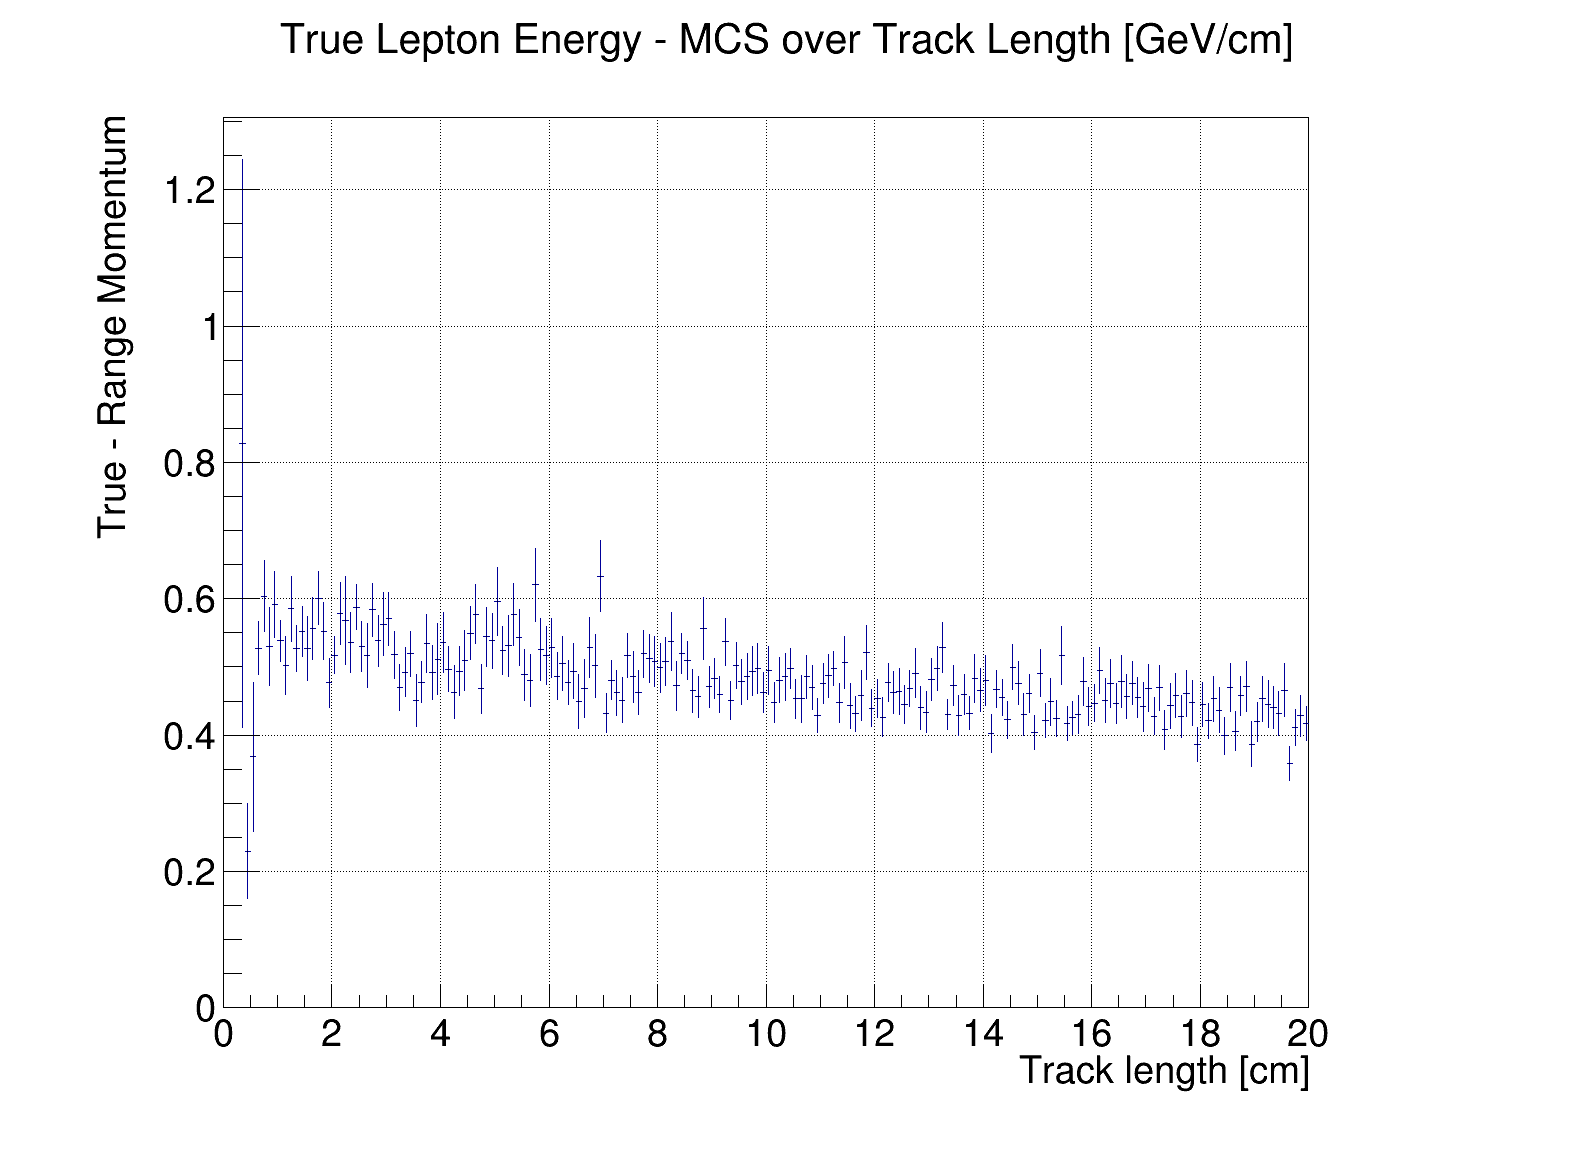

In [63]:
title = 'True Lepton Energy - MCS over Track Length [GeV/cm]'
xstart = 0
xend = 20
xbin = 200
ystart = -1
yend = 1
ybin = 200
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
#h_pos = ROOT.TH2F("h_pos",title,xbin,xstart,xend,ybin, ystart, yend)
#h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
h_pos = ROOT.TProfile("h_pos", title, xbin,xstart,xend)
overlay.Draw('MCNu_LeptonEnergy-TrackMomMCS_mom:TrackLength>>h_pos','track_key==muon_candidate_key && TrackMomMCS_mom<6','profz')
h_pos.SetXTitle("Track length [cm]")
h_pos.SetYTitle("True - MCS Momentum")

h_pos.Draw('')
c1.Draw()
c1.SaveAs(outputdir_png + "h_MCS_tracklength.png")
c1.SaveAs(outputdir_root + "h_MCS_tracklength.root")

h_pos = ROOT.TProfile("h_pos", title, xbin,xstart,xend)
overlay.Draw('MCNu_LeptonEnergy-TrackMomRange_mu:TrackLength>>h_pos','track_key==muon_candidate_key && TrackMomRange_mu<6','profz')
h_pos.SetXTitle("Track length [cm]")
h_pos.SetYTitle("True - Range Momentum")

h_pos.Draw('')
c1.Draw()
c1.SaveAs(outputdir_png + "h_range_tracklength.png")
c1.SaveAs(outputdir_root + "h_range_tracklength.root")

In [64]:
# Print initial efficiency and purity

NuCC.printEff('fidVol && muon && TrackLength>8')

Rejection on each sample:
Keep of    data:	96.19%	 reject:	3.81%
Keep of     ext:	95.03%	 reject:	4.97%
Keep of overlay:	96.78%	 reject:	3.22%
Keep of    dirt:	93.07%	 reject:	6.93%

Efficiency:		99.69%
Purity:			34.65%
Purity*Efficiency	34.54

Amount of    data:	108.02%
Amount of     ext:	36.64%
Amount of overlay:	58.42%
Amount of    dirt:	4.94%

Signal definition=  numu_lowpur: 2.10%	(3.60%)
Signal definition=   numu_other: 0.46%	(0.78%)
Signal definition=    numu_nomu: 4.33%	(7.41%)
Signal definition=      numu_ov: 10.51%	(18.00%)
Signal definition=  numu_signal: 34.65%	(59.31%)
Signal definition=      numu_nc: 6.36%	(10.89%)


In [65]:
NuCC.printEff('fidVol && muon && VtxDistance<10')

Rejection on each sample:
Keep of    data:	92.36%	 reject:	7.64%
Keep of     ext:	90.06%	 reject:	9.94%
Keep of overlay:	93.05%	 reject:	6.95%
Keep of    dirt:	90.14%	 reject:	9.86%

Efficiency:		95.44%
Purity:			34.67%
Purity*Efficiency	33.09

Amount of    data:	108.40%
Amount of     ext:	36.30%
Amount of overlay:	58.70%
Amount of    dirt:	5.00%

Signal definition=  numu_lowpur: 1.49%	(2.53%)
Signal definition=   numu_other: 0.48%	(0.81%)
Signal definition=    numu_nomu: 4.37%	(7.45%)
Signal definition=      numu_ov: 10.78%	(18.36%)
Signal definition=  numu_signal: 34.67%	(59.06%)
Signal definition=      numu_nc: 6.90%	(11.76%)


In [66]:
NuCC.printEff('fidVol && muon && VtxDistance<10 && TrackLength>8')

Rejection on each sample:
Keep of    data:	88.66%	 reject:	11.34%
Keep of     ext:	85.21%	 reject:	14.79%
Keep of overlay:	89.97%	 reject:	10.03%
Keep of    dirt:	83.43%	 reject:	16.57%

Efficiency:		95.15%
Purity:			36.11%
Purity*Efficiency	34.36

Amount of    data:	108.71%
Amount of     ext:	35.87%
Amount of overlay:	59.29%
Amount of    dirt:	4.83%

Signal definition=  numu_lowpur: 1.46%	(2.47%)
Signal definition=   numu_other: 0.45%	(0.76%)
Signal definition=    numu_nomu: 4.37%	(7.37%)
Signal definition=      numu_ov: 10.48%	(17.68%)
Signal definition=  numu_signal: 36.11%	(60.90%)
Signal definition=      numu_nc: 6.41%	(10.82%)


In [13]:
track_start_border_x = '(TrackStart_x <(-1.55+1) || TrackStart_x > (254.8-1))'
track_end_border_x = '(TrackEnd_x <(-1.55+1) || TrackEnd_x > (254.8-1))'
track_start_border_y = '(TrackStart_y <(-115.53+1) || TrackStart_y > (117.47-1))'
track_end_border_y = '(TrackEnd_y <(-115.53+1) || TrackEnd_y > (117.47-1))'
track_start_border_z = '(TrackStart_z <(0.1+1) || TrackStart_z > (1036.9-1))'
track_end_border_z = '(TrackEnd_z <(0.1+1) || TrackEnd_z > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)



True

In [19]:
NuCC.printEff('fidVol && muon && track_uncontained==0')

Rejection on each sample:
Keep of    data:	61.27%	 reject:	38.73%
Keep of     ext:	57.53%	 reject:	42.47%
Keep of overlay:	62.80%	 reject:	37.20%
Keep of    dirt:	65.67%	 reject:	34.33%

Efficiency:		52.83%
Purity:			28.88%
Purity*Efficiency	15.26

Amount of    data:	108.23%
Amount of     ext:	34.89%
Amount of overlay:	59.62%
Amount of    dirt:	5.48%

Signal definition=  numu_lowpur: 2.29%	(3.84%)
Signal definition=   numu_other: 0.54%	(0.90%)
Signal definition=    numu_nomu: 6.43%	(10.79%)
Signal definition=      numu_ov: 11.34%	(19.02%)
Signal definition=  numu_signal: 28.88%	(48.44%)
Signal definition=      numu_nc: 10.12%	(16.98%)


In [20]:
NuCC.printEff('fidVol && muon && nr_tracks_uncontained==0')

Rejection on each sample:
Keep of    data:	55.59%	 reject:	44.41%
Keep of     ext:	53.28%	 reject:	46.72%
Keep of overlay:	56.32%	 reject:	43.68%
Keep of    dirt:	58.51%	 reject:	41.49%

Efficiency:		48.88%
Purity:			29.47%
Purity*Efficiency	14.41

Amount of    data:	108.29%
Amount of     ext:	35.64%
Amount of overlay:	58.97%
Amount of    dirt:	5.39%

Signal definition=  numu_lowpur: 2.03%	(3.45%)
Signal definition=   numu_other: 0.56%	(0.95%)
Signal definition=    numu_nomu: 4.84%	(8.21%)
Signal definition=      numu_ov: 11.21%	(19.01%)
Signal definition=  numu_signal: 29.47%	(49.98%)
Signal definition=      numu_nc: 10.84%	(18.37%)


In [21]:
NuCC.printEff_sample('fidVol && muon','track_uncontained==0 &&')

Rejection on each sample:
Keep of    data:	100.00%	 reject:	0.00%
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		100.00%
Purity:			28.88%
Purity*Efficiency	28.88

Amount of    data:	108.23%
Amount of     ext:	34.89%
Amount of overlay:	59.62%
Amount of    dirt:	5.48%

Signal definition=  numu_lowpur: 2.29%	(3.84%)
Signal definition=   numu_other: 0.54%	(0.90%)
Signal definition=    numu_nomu: 6.43%	(10.79%)
Signal definition=      numu_ov: 11.34%	(19.02%)
Signal definition=  numu_signal: 28.88%	(48.44%)
Signal definition=      numu_nc: 10.12%	(16.98%)


In [22]:
NuCC.printEff_sample('fidVol && muon','nr_tracks_uncontained==0 &&')

Rejection on each sample:
Keep of    data:	100.00%	 reject:	0.00%
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		100.00%
Purity:			29.47%
Purity*Efficiency	29.47

Amount of    data:	108.29%
Amount of     ext:	35.64%
Amount of overlay:	58.97%
Amount of    dirt:	5.39%

Signal definition=  numu_lowpur: 2.03%	(3.45%)
Signal definition=   numu_other: 0.56%	(0.95%)
Signal definition=    numu_nomu: 4.84%	(8.21%)
Signal definition=      numu_ov: 11.21%	(19.01%)
Signal definition=  numu_signal: 29.47%	(49.98%)
Signal definition=      numu_nc: 10.84%	(18.37%)


In [25]:
NuCC.printEff_sample('fidVol && muon && nr_crthit_beam_tres<1','track_uncontained==0 &&')

Rejection on each sample:
Keep of    data:	68.38%	 reject:	31.62%
Keep of     ext:	52.23%	 reject:	47.77%
Keep of overlay:	90.34%	 reject:	9.66%
Keep of    dirt:	71.47%	 reject:	28.53%

Efficiency:		94.53%
Purity:			35.92%
Purity*Efficiency	33.96

Amount of    data:	97.36%
Amount of     ext:	23.98%
Amount of overlay:	70.87%
Amount of    dirt:	5.15%

Signal definition=  numu_lowpur: 2.57%	(3.63%)
Signal definition=   numu_other: 0.67%	(0.94%)
Signal definition=    numu_nomu: 6.78%	(9.57%)
Signal definition=      numu_ov: 12.02%	(16.96%)
Signal definition=  numu_signal: 35.92%	(50.69%)
Signal definition=      numu_nc: 12.89%	(18.19%)


In [26]:
NuCC.printEff_sample('fidVol && muon && nr_crthit_beam_tres<1','nr_tracks_uncontained==0 &&')

Rejection on each sample:
Keep of    data:	68.83%	 reject:	31.17%
Keep of     ext:	52.38%	 reject:	47.62%
Keep of overlay:	91.65%	 reject:	8.35%
Keep of    dirt:	71.51%	 reject:	28.49%

Efficiency:		94.72%
Purity:			36.46%
Purity*Efficiency	34.54

Amount of    data:	97.35%
Amount of     ext:	24.38%
Amount of overlay:	70.59%
Amount of    dirt:	5.03%

Signal definition=  numu_lowpur: 2.32%	(3.28%)
Signal definition=   numu_other: 0.70%	(0.98%)
Signal definition=    numu_nomu: 5.59%	(7.92%)
Signal definition=      numu_ov: 11.79%	(16.71%)
Signal definition=  numu_signal: 36.46%	(51.65%)
Signal definition=      numu_nc: 13.71%	(19.43%)


In [27]:
NuCC.printEff('fidVol && muon && (nr_crthit_beam_tres<1 || track_uncontained!=0)')

Rejection on each sample:
Keep of    data:	80.62%	 reject:	19.38%
Keep of     ext:	72.52%	 reject:	27.48%
Keep of overlay:	93.93%	 reject:	6.07%
Keep of    dirt:	81.27%	 reject:	18.73%

Efficiency:		97.11%
Purity:			37.94%
Purity*Efficiency	36.84

Amount of    data:	101.76%
Amount of     ext:	31.43%
Amount of overlay:	63.72%
Amount of    dirt:	4.85%

Signal definition=  numu_lowpur: 2.22%	(3.48%)
Signal definition=   numu_other: 0.54%	(0.85%)
Signal definition=    numu_nomu: 4.17%	(6.55%)
Signal definition=      numu_ov: 11.07%	(17.37%)
Signal definition=  numu_signal: 37.94%	(59.53%)
Signal definition=      numu_nc: 7.77%	(12.19%)


In [28]:
NuCC.printEff('fidVol && muon && (nr_crthit_beam_tres<1 || nr_tracks_uncontained>0)')

Rejection on each sample:
Keep of    data:	82.67%	 reject:	17.33%
Keep of     ext:	74.63%	 reject:	25.37%
Keep of overlay:	95.30%	 reject:	4.70%
Keep of    dirt:	83.33%	 reject:	16.67%

Efficiency:		97.42%
Purity:			37.32%
Purity*Efficiency	36.36

Amount of    data:	102.34%
Amount of     ext:	31.72%
Amount of overlay:	63.40%
Amount of    dirt:	4.87%

Signal definition=  numu_lowpur: 2.25%	(3.55%)
Signal definition=   numu_other: 0.54%	(0.85%)
Signal definition=    numu_nomu: 4.63%	(7.30%)
Signal definition=      numu_ov: 11.02%	(17.38%)
Signal definition=  numu_signal: 37.32%	(58.87%)
Signal definition=      numu_nc: 7.64%	(12.04%)


In [39]:
# Define CRT cut

data.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")


True

In [40]:
# Define CRT cut

data.SetAlias("crt_cut2","((abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1) && crtt0_plane!=3)")
ext.SetAlias("crt_cut2","((abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1) && crtt0_plane!=3)")
overlay.SetAlias("crt_cut2","((abs(crtt0_time-4)<0.8 || crtt0_time==-1) && crtt0_plane!=3)")
dirt.SetAlias("crt_cut2","((abs(crtt0_time-4)<0.8 || crtt0_time==-1) && crtt0_plane!=3)")


True

In [41]:
NuCC.printEff_sample('fidVol && muon','track_uncontained==1 &&')

Rejection on each sample:
Keep of    data:	100.00%	 reject:	0.00%
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		100.00%
Purity:			40.33%
Purity*Efficiency	40.33

Amount of    data:	106.99%
Amount of     ext:	40.29%
Amount of overlay:	55.23%
Amount of    dirt:	4.48%

Signal definition=  numu_lowpur: 1.80%	(3.27%)
Signal definition=   numu_other: 0.40%	(0.72%)
Signal definition=    numu_nomu: 1.07%	(1.95%)
Signal definition=      numu_ov: 9.94%	(18.00%)
Signal definition=  numu_signal: 40.33%	(73.02%)
Signal definition=      numu_nc: 1.69%	(3.06%)


In [42]:
NuCC.printEff_sample('fidVol && muon','nr_tracks_uncontained>0 &&')

Rejection on each sample:
Keep of    data:	100.00%	 reject:	0.00%
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		100.00%
Purity:			38.14%
Purity*Efficiency	38.14

Amount of    data:	107.06%
Amount of     ext:	38.68%
Amount of overlay:	56.60%
Amount of    dirt:	4.73%

Signal definition=  numu_lowpur: 2.18%	(3.86%)
Signal definition=   numu_other: 0.39%	(0.68%)
Signal definition=    numu_nomu: 3.72%	(6.58%)
Signal definition=      numu_ov: 10.28%	(18.17%)
Signal definition=  numu_signal: 38.14%	(67.39%)
Signal definition=      numu_nc: 1.88%	(3.32%)


In [43]:
NuCC.printEff_sample('fidVol && muon && crt_cut','track_uncontained==1 &&')

Rejection on each sample:
Keep of    data:	88.67%	 reject:	11.33%
Keep of     ext:	82.94%	 reject:	17.06%
Keep of overlay:	92.76%	 reject:	7.24%
Keep of    dirt:	86.89%	 reject:	13.11%

Efficiency:		96.35%
Purity:			43.89%
Purity*Efficiency	42.29

Amount of    data:	107.14%
Amount of     ext:	37.74%
Amount of overlay:	57.86%
Amount of    dirt:	4.40%

Signal definition=  numu_lowpur: 1.26%	(2.18%)
Signal definition=   numu_other: 0.42%	(0.73%)
Signal definition=    numu_nomu: 1.16%	(2.01%)
Signal definition=      numu_ov: 9.58%	(16.56%)
Signal definition=  numu_signal: 43.89%	(75.85%)
Signal definition=      numu_nc: 1.55%	(2.67%)


In [44]:
NuCC.printEff('fidVol && muon && (crt_cut || track_uncontained==0)')

Rejection on each sample:
Keep of    data:	95.61%	 reject:	4.39%
Keep of     ext:	92.76%	 reject:	7.24%
Keep of overlay:	97.31%	 reject:	2.69%
Keep of    dirt:	95.50%	 reject:	4.50%

Efficiency:		98.28%
Purity:			34.31%
Purity*Efficiency	33.72

Amount of    data:	107.83%
Amount of     ext:	35.92%
Amount of overlay:	58.99%
Amount of    dirt:	5.09%

Signal definition=  numu_lowpur: 1.92%	(3.25%)
Signal definition=   numu_other: 0.50%	(0.84%)
Signal definition=    numu_nomu: 4.53%	(7.68%)
Signal definition=      numu_ov: 10.70%	(18.15%)
Signal definition=  numu_signal: 34.31%	(58.16%)
Signal definition=      numu_nc: 7.02%	(11.90%)


In [45]:
NuCC.printEff('fidVol && muon && nr_track_asso_out_uncon==0')

Rejection on each sample:
Keep of    data:	93.25%	 reject:	6.75%
Keep of     ext:	91.38%	 reject:	8.62%
Keep of overlay:	96.52%	 reject:	3.48%
Keep of    dirt:	94.56%	 reject:	5.44%

Efficiency:		97.63%
Purity:			34.45%
Purity*Efficiency	33.63

Amount of    data:	106.30%
Amount of     ext:	35.77%
Amount of overlay:	59.14%
Amount of    dirt:	5.09%

Signal definition=  numu_lowpur: 1.89%	(3.19%)
Signal definition=   numu_other: 0.50%	(0.84%)
Signal definition=    numu_nomu: 4.50%	(7.61%)
Signal definition=      numu_ov: 10.72%	(18.13%)
Signal definition=  numu_signal: 34.45%	(58.25%)
Signal definition=      numu_nc: 7.07%	(11.96%)


In [46]:
NuCC.printEff('fidVol && muon && (crt_cut || track_uncontained==0) && (nr_crthit_beam_tres<1 || track_uncontained!=0)')

Rejection on each sample:
Keep of    data:	76.24%	 reject:	23.76%
Keep of     ext:	65.27%	 reject:	34.73%
Keep of overlay:	91.24%	 reject:	8.76%
Keep of    dirt:	76.76%	 reject:	23.24%

Efficiency:		95.39%
Purity:			39.32%
Purity*Efficiency	37.51

Amount of    data:	101.54%
Amount of     ext:	29.85%
Amount of overlay:	65.32%
Amount of    dirt:	4.83%

Signal definition=  numu_lowpur: 2.01%	(3.08%)
Signal definition=   numu_other: 0.56%	(0.86%)
Signal definition=    numu_nomu: 4.38%	(6.71%)
Signal definition=      numu_ov: 10.98%	(16.81%)
Signal definition=  numu_signal: 39.32%	(60.20%)
Signal definition=      numu_nc: 8.05%	(12.32%)


In [47]:
NuCC.printEff('fidVol && muon && nr_crthit_beam_tres<1')

Rejection on each sample:
Keep of    data:	66.26%	 reject:	33.74%
Keep of     ext:	53.26%	 reject:	46.74%
Keep of overlay:	86.30%	 reject:	13.70%
Keep of    dirt:	69.43%	 reject:	30.57%

Efficiency:		86.94%
Purity:			39.60%
Purity*Efficiency	34.43

Amount of    data:	97.50%
Amount of     ext:	26.91%
Amount of overlay:	68.26%
Amount of    dirt:	4.83%

Signal definition=  numu_lowpur: 2.46%	(3.60%)
Signal definition=   numu_other: 0.60%	(0.88%)
Signal definition=    numu_nomu: 4.76%	(6.98%)
Signal definition=      numu_ov: 11.82%	(17.31%)
Signal definition=  numu_signal: 39.60%	(58.01%)
Signal definition=      numu_nc: 9.01%	(13.19%)


In [48]:
NuCC.printEff('fidVol && muon && (crt_cut2 || track_uncontained==0) && (nr_crthit_beam_tres<1 || track_uncontained!=0)')

Rejection on each sample:
Keep of    data:	75.59%	 reject:	24.41%
Keep of     ext:	63.51%	 reject:	36.49%
Keep of overlay:	91.19%	 reject:	8.81%
Keep of    dirt:	76.75%	 reject:	23.25%

Efficiency:		95.31%
Purity:			39.62%
Purity*Efficiency	37.77

Amount of    data:	101.53%
Amount of     ext:	29.29%
Amount of overlay:	65.84%
Amount of    dirt:	4.87%

Signal definition=  numu_lowpur: 2.03%	(3.08%)
Signal definition=   numu_other: 0.57%	(0.86%)
Signal definition=    numu_nomu: 4.42%	(6.72%)
Signal definition=      numu_ov: 11.07%	(16.81%)
Signal definition=  numu_signal: 39.62%	(60.19%)
Signal definition=      numu_nc: 8.11%	(12.33%)


Efficiency:	81.63%
Purity:		58.70%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_energy_Wouter.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_energy_Wouter.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_theta_Wouter.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_theta_Wouter.ro

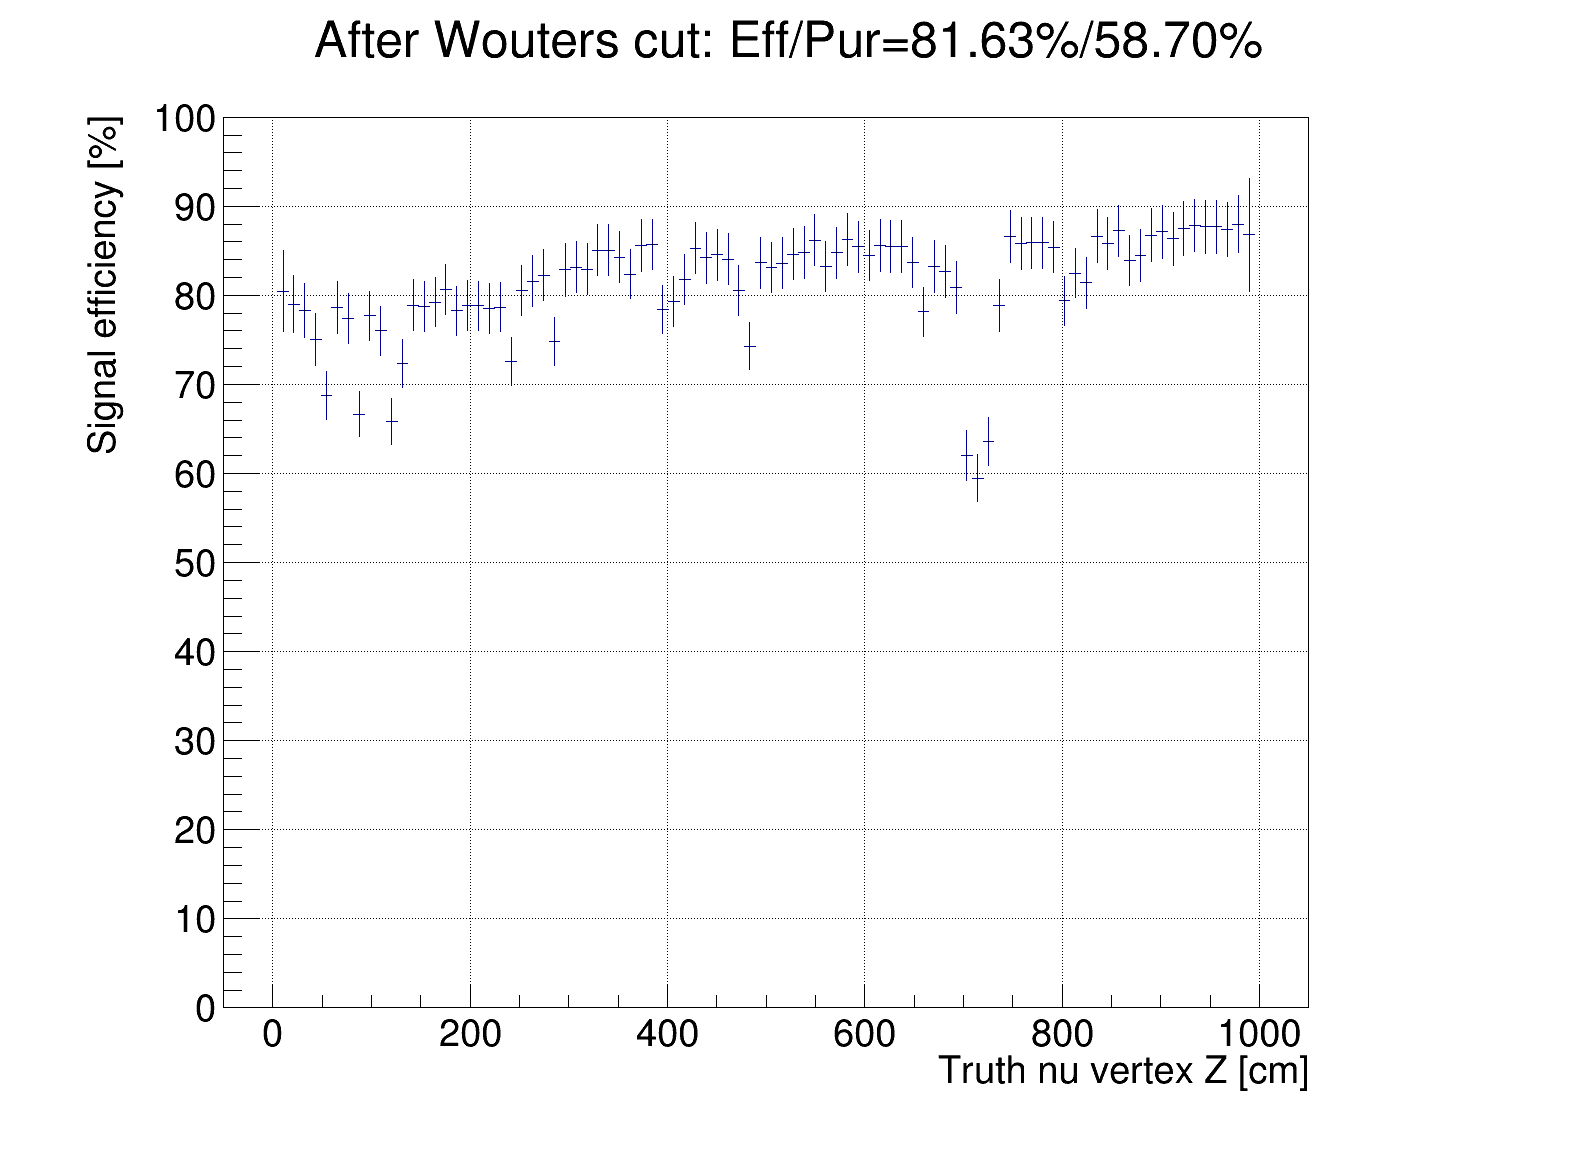

In [17]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)


name = '_Wouter'
title = 'After Wouters cut:'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)
h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth enutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)
h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth neutrino cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)
h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco neutrino phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



Efficiency:	83.11%
Purity:		62.65%
Efficiency 2:	65.53%
Purity 2:		31.39%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_energy_Wouter_forBackward_reco.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_energy_Wouter_forBackward_reco.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta2 

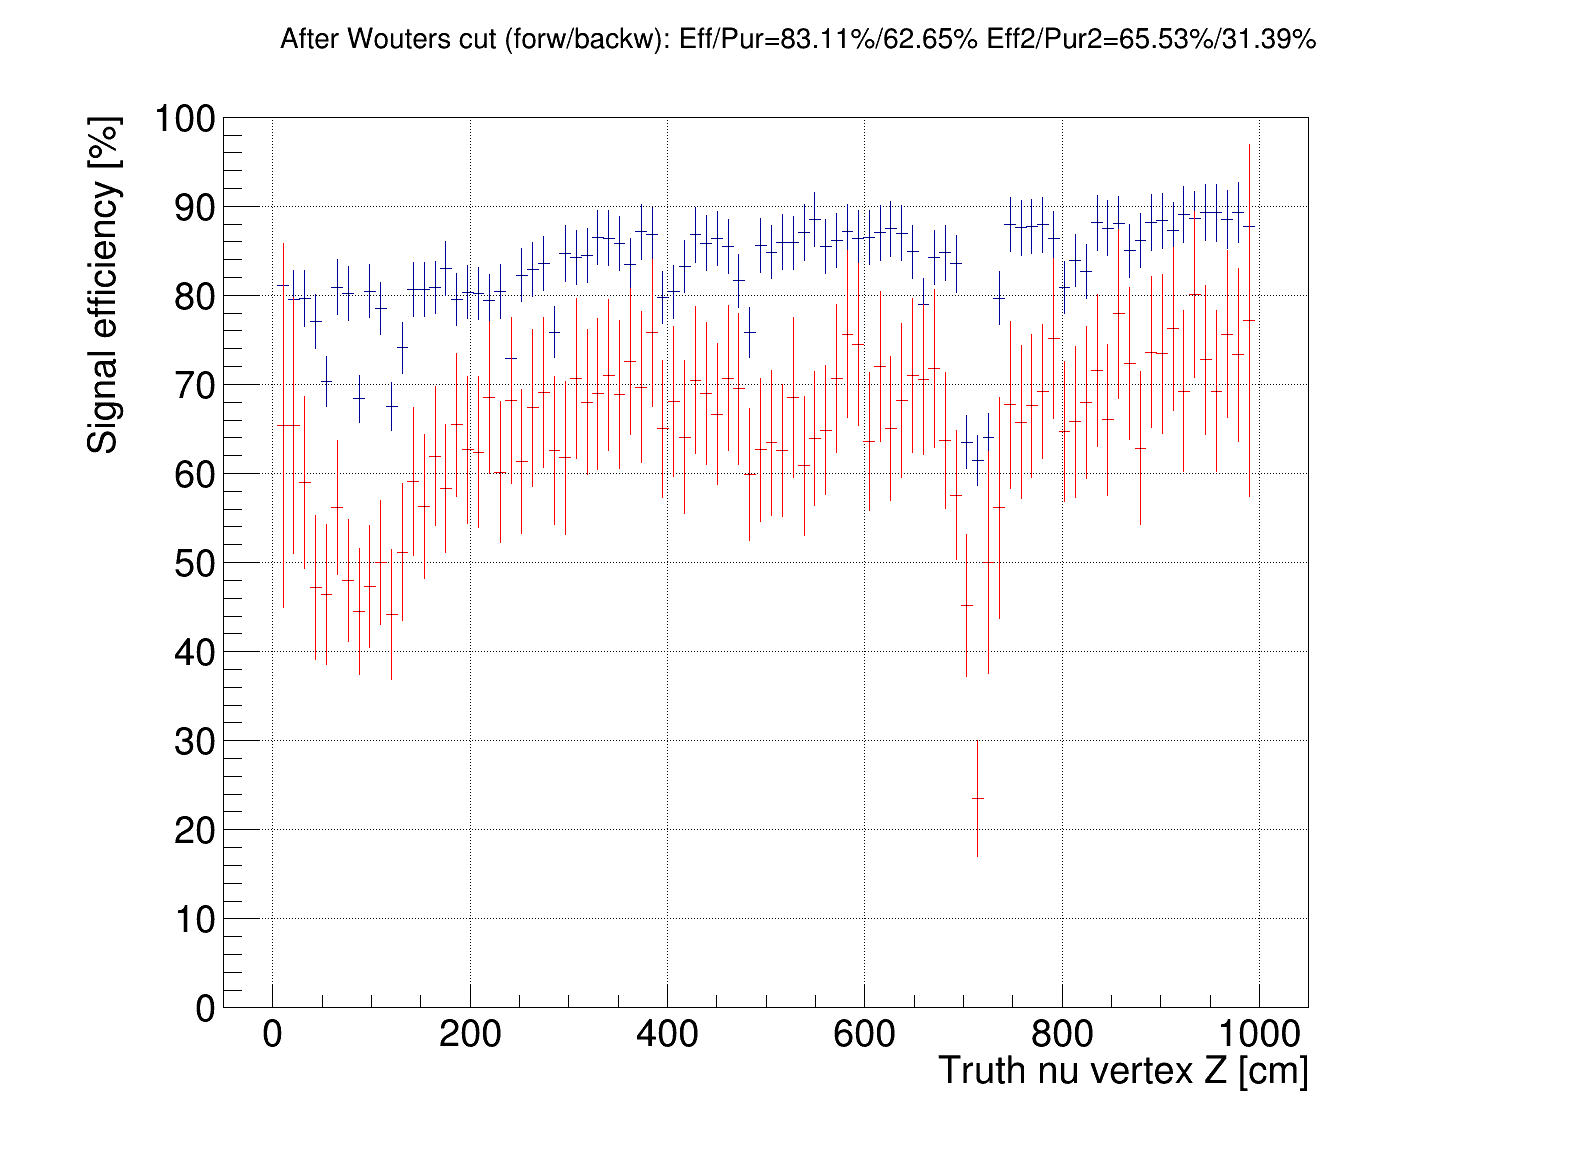

In [30]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && cos(TrackTheta)>0"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)>0"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)>0'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)

nenner_cut2 = "numu_signal && muon && cos(TrackTheta)<0"
zahler_cut2 = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)<0"
cut2 = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)<0'

efficiency2 = overlay.GetEntries(zahler_cut2)*100.0/overlay.GetEntries(nenner_cut2)
purity2 = overlay.GetEntries(cut2+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut2)

print 'Efficiency 2:\t{0:0.2f}%'.format(efficiency2)
print 'Purity 2:\t\t{0:0.2f}%'.format(  purity2)


name = '_Wouter_forBackward_reco'
title = 'After Wouters cut (forw/backw):'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)+' Eff2/Pur2={0:0.2f}%'.format( efficiency2)+'/{0:0.2f}%'.format(purity2)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy2',zahler_cut2)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner_cut2)
h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
h_init_eff_energy2.Scale(100)
h_init_eff_energy2.SetLineColor(2)

h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
h_init_eff_energy2.Draw("same")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)

h_init_eff_theta2 = ROOT.TH1F("h_init_eff_theta2",title,xbin,xstart,xend)
h_init_eff_theta_12 = ROOT.TH1F("h_init_eff_theta_12",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta2',zahler_cut2)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_12',nenner_cut2)
h_init_eff_theta_12.Sumw2()
h_init_eff_theta2.Divide(h_init_eff_theta_12)
h_init_eff_theta2.Scale(100)
h_init_eff_theta2.SetLineColor(2)

h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth lepton cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
h_init_eff_theta2.Draw("same E")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)

h_init_eff_phi2 = ROOT.TH1F("h_init_eff_phi2",title,xbin,xstart,xend)
h_init_eff_phi_12 = ROOT.TH1F("h_init_eff_phi_12",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi2',zahler_cut2)
overlay.Draw('TrackPhi>>h_init_eff_phi_12',nenner_cut2)
h_init_eff_phi_12.Sumw2()
h_init_eff_phi2.Divide(h_init_eff_phi_12)
h_init_eff_phi2.Scale(100)
h_init_eff_phi2.SetLineColor(2)

h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco lepton phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
h_init_eff_phi2.Draw("same e")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vx>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vy>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vz>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



In [26]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && !track_end_uncontained"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && !track_end_uncontained"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && !track_end_uncontained'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)

nenner_cut2 = "numu_signal && muon && track_end_uncontained"
zahler_cut2 = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && track_end_uncontained"
cut2 = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && track_end_uncontained'

efficiency2 = overlay.GetEntries(zahler_cut2)*100.0/overlay.GetEntries(nenner_cut2)
purity2 = overlay.GetEntries(cut2+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut2)

print 'Efficiency 2:\t{0:0.2f}%'.format(efficiency2)
print 'Purity 2:\t\t{0:0.2f}%'.format(  purity2)


name = '_Wouter_contained'
title = 'After Wouters cut (track_end_uncontained/!):'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)+' Eff2/Pur2={0:0.2f}%'.format( efficiency2)+'/{0:0.2f}%'.format(purity2)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy2',zahler_cut2)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner_cut2)
h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
h_init_eff_energy2.Scale(100)
h_init_eff_energy2.SetLineColor(2)

h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
h_init_eff_energy2.Draw("same")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)

h_init_eff_theta2 = ROOT.TH1F("h_init_eff_theta2",title,xbin,xstart,xend)
h_init_eff_theta_12 = ROOT.TH1F("h_init_eff_theta_12",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta2',zahler_cut2)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_12',nenner_cut2)
h_init_eff_theta_12.Sumw2()
h_init_eff_theta2.Divide(h_init_eff_theta_12)
h_init_eff_theta2.Scale(100)
h_init_eff_theta2.SetLineColor(2)

h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth lepton cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
h_init_eff_theta2.Draw("same E")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)

h_init_eff_phi2 = ROOT.TH1F("h_init_eff_phi2",title,xbin,xstart,xend)
h_init_eff_phi_12 = ROOT.TH1F("h_init_eff_phi_12",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi2',zahler_cut2)
overlay.Draw('TrackPhi>>h_init_eff_phi_12',nenner_cut2)
h_init_eff_phi_12.Sumw2()
h_init_eff_phi2.Divide(h_init_eff_phi_12)
h_init_eff_phi2.Scale(100)
h_init_eff_phi2.SetLineColor(2)

h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco lepton phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
h_init_eff_phi2.Draw("same e")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vx>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vy>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vz>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



Efficiency:	80.95%
Purity:		58.92%
Efficiency 2:	84.34%
Purity 2:		57.84%


AttributeError: 'PyROOT_NoneType' object has no attribute 'Draw'

Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).


Efficiency:	71.05%
Purity:		39.55%
Efficiency 2:	84.13%
Purity 2:		65.00%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_energy_Wouter_NuTracks.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_energy_Wouter_NuTracks.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta2 (Potential memor

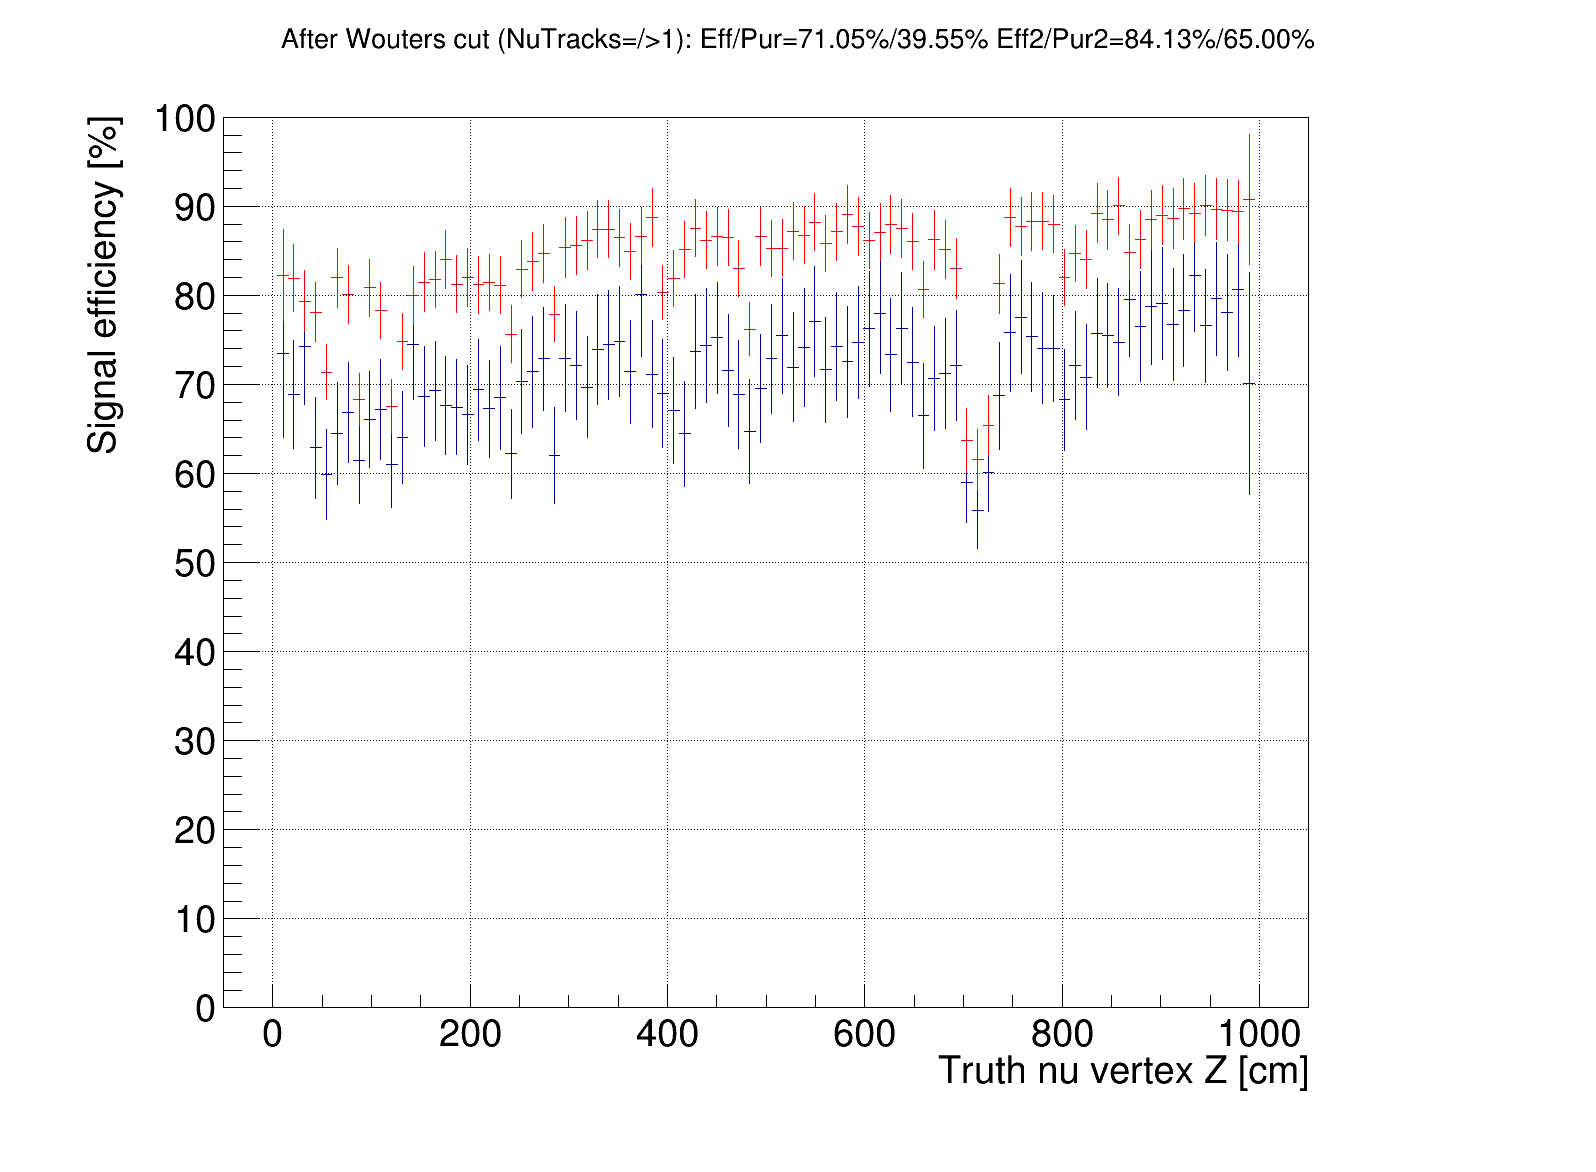

In [31]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && NuTracks==1"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks==1"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks==1'

#efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
#purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)

nenner_cut2 = "numu_signal && muon && NuTracks>1"
zahler_cut2 = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks>1"
cut2 = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks>1'

#efficiency2 = overlay.GetEntries(zahler_cut2)*100.0/overlay.GetEntries(nenner_cut2)
#purity2 = overlay.GetEntries(cut2+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut2)

print 'Efficiency 2:\t{0:0.2f}%'.format(efficiency2)
print 'Purity 2:\t\t{0:0.2f}%'.format(  purity2)


name = '_Wouter_NuTracks'
title = 'After Wouters cut (NuTracks=/>1):'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)+' Eff2/Pur2={0:0.2f}%'.format( efficiency2)+'/{0:0.2f}%'.format(purity2)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy2',zahler_cut2)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner_cut2)
h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
h_init_eff_energy2.Scale(100)
h_init_eff_energy2.SetLineColor(2)

h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
h_init_eff_energy2.Draw("same")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)

h_init_eff_theta2 = ROOT.TH1F("h_init_eff_theta2",title,xbin,xstart,xend)
h_init_eff_theta_12 = ROOT.TH1F("h_init_eff_theta_12",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta2',zahler_cut2)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_12',nenner_cut2)
h_init_eff_theta_12.Sumw2()
h_init_eff_theta2.Divide(h_init_eff_theta_12)
h_init_eff_theta2.Scale(100)
h_init_eff_theta2.SetLineColor(2)

h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth lepton cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
h_init_eff_theta2.Draw("same E")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)

h_init_eff_phi2 = ROOT.TH1F("h_init_eff_phi2",title,xbin,xstart,xend)
h_init_eff_phi_12 = ROOT.TH1F("h_init_eff_phi_12",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi2',zahler_cut2)
overlay.Draw('TrackPhi>>h_init_eff_phi_12',nenner_cut2)
h_init_eff_phi_12.Sumw2()
h_init_eff_phi2.Divide(h_init_eff_phi_12)
h_init_eff_phi2.Scale(100)
h_init_eff_phi2.SetLineColor(2)

h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco lepton phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
h_init_eff_phi2.Draw("same e")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vx>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vy>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vz>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")

